In [1]:
from matplotlib import pyplot as plt
import pandas as pd

# Pareto Limitation

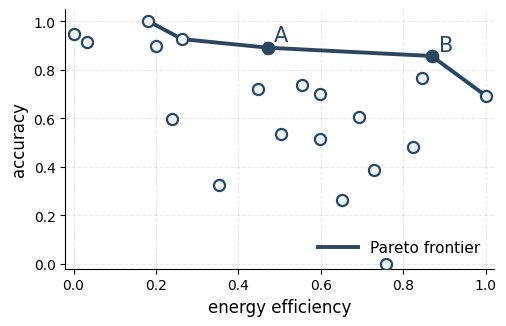

In [2]:
df = pd.read_excel("perf_llms.xlsx")
def norm_min_max(df: pd.DataFrame, col: str):
    values = df[col]
    return (values - values.min()) / (values.max() - values.min())
gpu = "A100"
task = "chat"
df = df[(df["gpu"] == gpu) & (df["task"] == task)]
df = df.reset_index(drop=True)
df["average"] = (df["arc"] + df["hellaswag"] + df["truthfulqa"]) / 3
df["avg_norm"] = norm_min_max(df, "average")
df["energy_norm"] = norm_min_max(df, "energy")
df["latency_norm"] = norm_min_max(df, "latency")
df = df.drop(columns=["gpu", "task", "arc", "hellaswag", "truthfulqa", "parameters"])
df["ene_eff"] = 1 - df["energy_norm"]
df["perf"] = df["avg_norm"]


def identify_all_pareto_optimals(x_points, y_points, models):
    all_pareto = []
    x_points_copy = x_points.copy()
    y_points_copy = y_points.copy()
    while len(x_points_copy) != 0:
        pareto_x = []
        pareto_y = []
        model_names_pareto = []
        non_pareto_x = []
        non_pareto_y = []
        model_names_non_pareto = []
        for i in range(len(x_points_copy)):
            x = x_points_copy[i]
            y = y_points_copy[i]
            mname = models[i]
            is_greater = True
            for j in range(len(x_points_copy)):
                if j == i:
                    continue
                new_x = x_points_copy[j]
                new_y = y_points_copy[j]
                if new_x > x and new_y >= y:
                    is_greater = False
                    break
                if new_y > y and new_x >= x:
                    is_greater = False
                    break
            if is_greater:
                pareto_x.append(x)
                pareto_y.append(y)
                model_names_pareto.append(mname)
            else:
                non_pareto_x.append(x)
                non_pareto_y.append(y)
                model_names_non_pareto.append(mname)
        all_pareto.append((pareto_x, pareto_y, model_names_pareto))
        x_points_copy = non_pareto_x
        y_points_copy = non_pareto_y
        models = model_names_non_pareto
    return all_pareto



all_pareto = identify_all_pareto_optimals(
    df["ene_eff"], df["perf"], df["model"]
)

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# (Optional) consistent, paper-friendly typography
mpl.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

point_color   = "#1B7F5A"   # deep, colorblind-safe teal for scatter
point_edge    = "#FFFFFF"   # subtle white outline
frontier_col  = "#2B465F"   # slate blue for Pareto frontier
frontier_mcol = "#F2F5F7"   # light fill for frontier markers

fig, ax = plt.subplots(figsize=(5.2, 3.4))

# scatter of all models
ax.scatter(
    df["ene_eff"], df["perf"],
    s=64,
    facecolors=frontier_mcol,
    edgecolors=frontier_col,
    linewidths=1.6,
    zorder=4,
)
# plot Pareto frontier(s) + highlight the frontier points
for i, (pareto_x, pareto_y, model_names) in enumerate(all_pareto):
    xs, ys, names = zip(*sorted(zip(pareto_x, pareto_y, model_names), key=lambda t: t[0]))
    ax.plot(
        xs, ys,
        color=frontier_col,
        linewidth=2.8,
        zorder=3,
        label="Pareto frontier" if i == 0 else None,
    )
    break
ax.scatter(df.iloc[1]["ene_eff"], df.iloc[1]["perf"], s=64,
    facecolors=frontier_col,
    edgecolors=frontier_col,
    linewidths=1.6,
    zorder=7,)
ax.scatter(df.iloc[12]["ene_eff"], df.iloc[12]["perf"], s=64,
    facecolors=frontier_col,
    edgecolors=frontier_col,
    linewidths=1.6,
    zorder=7,)
    

# labels, limits, ticks, grid
ax.set_xlabel("energy efficiency")
ax.set_ylabel("accuracy")
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.05)


ax.grid(which="major", linestyle="--", alpha=0.25, linewidth=0.8)

# legend
leg = ax.legend(loc="lower right", frameon=False, handlelength=2.6)

# annotations (adjust xy as needed)
ax.annotate("A", xy=(0.47, 0.89), xytext=(5, 5), textcoords="offset points",
            fontsize=15, color=frontier_col)
ax.annotate("B", xy=(0.87, 0.85), xytext=(5, 5), textcoords="offset points",
            fontsize=15, color=frontier_col)

fig.tight_layout()
plt.savefig("pareto_limitation.pdf")

# Save for paper (vector + high-DPI raster)
# plt.savefig("pareto_frontier.pdf", bbox_inches="tight")   # vector for journals
# plt.savefig("pareto_frontier.png", dpi=400, bbox_inches="tight")


In [3]:
df

,model,energy,throughput,response_length,latency,average,avg_norm,energy_norm,latency_norm,ene_eff,perf
0,MetaAI/Llama-7B,335.26,27.47,60.65,1.99,54.310000,0.693310,0.000000,0.000000,1.000000,0.693310
1,MetaAI/Llama-13B,631.57,23.20,76.47,2.97,59.023333,0.856401,0.130788,0.052434,0.869212,0.856401
2,tatsu-lab/alpaca-7B,684.17,28.00,132.85,4.63,56.370000,0.764591,0.154005,0.141252,0.845995,0.764591
3,RWKV/rwkv-raven-7b,735.77,61.52,214.78,3.08,48.136667,0.479700,0.176780,0.058320,0.823220,0.479700
4,Neutralzz/BiLLa-7B-SFT,881.44,33.57,161.81,4.79,34.273333,0.000000,0.241077,0.149813,0.758923,0.000000
5,H2OAI/H2OGPT-oasst1-7B,951.08,33.20,212.46,6.39,45.450000,0.386736,0.271816,0.235420,0.728184,0.386736
6,FreedomIntelligence/phoenix-inst-chat-7b,1030.89,55.84,240.34,4.12,51.756667,0.604960,0.307043,0.113965,0.692957,0.604960
7,StabilityAI/stablelm-tuned-alpha-7b,1124.40,45.42,243.88,5.21,41.906667,0.264129,0.348317,0.172285,0.651683,0.264129
8,databricks/dolly-v2-12B,1242.92,22.11,153.76,7.94,49.116667,0.513610,0.400630,0.318352,0.599370,0.513610
9,Salesforce/xgen-7b-8k-inst,1246.09,49.54,275.27,5.60,54.470000,0.698847,0.402030,0.193151,0.597970,0.698847


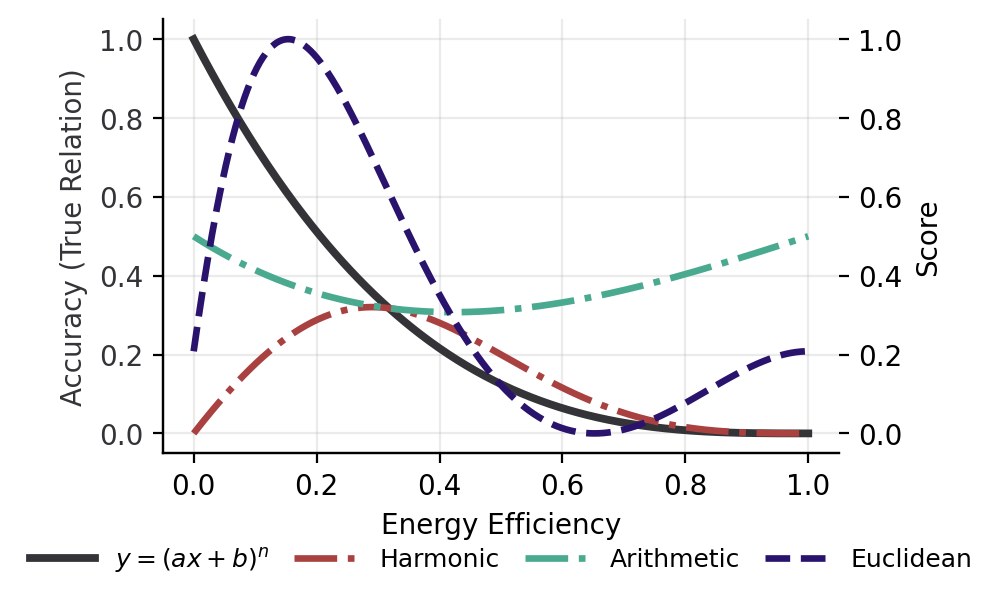

In [19]:
# Single figure with twin y-axes:
# Left y-axis: true relation b(a) = -(a-1)^3
# Right y-axis: mean scores (harmonic, geometric, arithmetic) vs a
# Saved as high-res PNG + vector PDF/SVG.

import numpy as np
import matplotlib.pyplot as plt

# Data
a = np.linspace(0, 1.0, 400)
b = -(a - 1.0)**3

harmonic = np.divide(2*a*b, a+b, out=np.zeros_like(a), where=(a+b)!=0)
geometric = np.sqrt(a*b)
arithmetic = (a + b) / 2
euc_dis = ((1-a) ** 2 + (1-b) **2) ** 0.5 
euc_positive = (1 / (euc_dis + 1e-7))
euc_norm = (euc_positive - euc_positive.min()) / (euc_positive.max() - euc_positive.min())

# Colors (Okabe–Ito) + neutral gray for the relation
COL_REL = "#343438"
COL_H   = "#A94141"
# COL_G   = "#A94141"
COL_A   = "#49AA90"
COL_E   = "#29136D"

fig, ax_left = plt.subplots(figsize=(4.8, 3.2), dpi=200)

# Left axis: true relation
l0, = ax_left.plot(a, b, color=COL_REL, linewidth=2.8, label=r"$b=-(a-1)^3$")
ax_left.set_xlabel("Energy Efficiency", fontsize=10)
ax_left.set_ylabel("Accuracy (True Relation)", fontsize=10, color=COL_REL)
ax_left.tick_params(axis='y', labelcolor=COL_REL)
ax_left.grid(True, which="both", alpha=0.25, linewidth=0.8)

# Right axis: means
ax_right = ax_left.twinx()
l1, = ax_right.plot(a, harmonic,   color=COL_H, linewidth=2.4, linestyle="-.", label="Harmonic")
# l2, = ax_right.plot(a, geometric,  color=COL_G, linewidth=2.4, linestyle="--", label="Geometric")
l2, = ax_right.plot(a, arithmetic, color=COL_A, linewidth=2.4, linestyle="-.", label="Arithmetic")
l3, = ax_right.plot(a, euc_norm, color=COL_E, linewidth=2.4, linestyle="--", label="Euclidean")
ax_right.set_ylabel("Score", fontsize=10)
ax_right.tick_params(axis='y')

# Harmonize y-lims to avoid cramped curves on right
ymin = min(harmonic.min(), arithmetic.min(), euc_norm.min())
ymax = max(harmonic.max(), arithmetic.max(), euc_norm.max())
pad = 0.03 * (ymax - ymin if ymax > ymin else 1.0)
ax_right.set_ylim(ymin - pad, ymax + pad)
# After setting all plots
ax_right.set_ylim(ax_left.get_ylim())

# Single, combined legend below the plot
handles = [l0, l1, l2, l3]
labels = [h.get_label() for h in handles]
labels[0] = r"$y = (ax+b)^n$"
ax_left.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.16),
               ncol=4, frameon=False, fontsize=9, handlelength=2.6, columnspacing=1.0)

fig.tight_layout()
plt.savefig("mean_limitations.pdf")


plt.show()


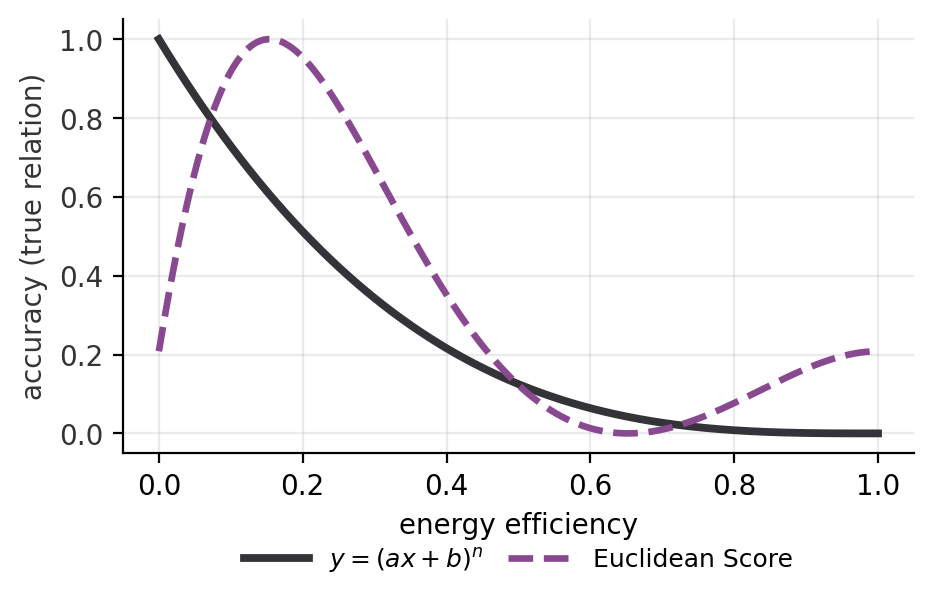

In [5]:
euc_dis = ((1-a) ** 2 + (1-b) **2) ** 0.5 
euc_positive = (1 / (euc_dis + 1e-7))
euc_norm = (euc_positive - euc_positive.min()) / (euc_positive.max() - euc_positive.min())


fig, ax_left = plt.subplots(figsize=(4.8, 3.2), dpi=200)
# Left axis: true relation
l0, = ax_left.plot(a, b, color=COL_REL, linewidth=2.8, label=r"$b=-(a-1)^3$")
ax_left.set_xlabel("energy efficiency", fontsize=10)
ax_left.set_ylabel("accuracy (true relation)", fontsize=10, color=COL_REL)
ax_left.tick_params(axis='y', labelcolor=COL_REL)
ax_left.grid(True, which="both", alpha=0.25, linewidth=0.8)
l1, = ax_left.plot(a, euc_norm, color="#884990", linewidth=2.4, linestyle="--", label="Euclidean Score")


# Single, combined legend below the plot
handles = [l0, l1]
labels = [h.get_label() for h in handles]
labels[0] = r"$y = (ax+b)^n$"
ax_left.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.16),
               ncol=4, frameon=False, fontsize=9, handlelength=2.6, columnspacing=1.0)

fig.tight_layout()
plt.savefig("euclidean.pdf")

In [6]:
ymin, ymax

(np.float64(-0.0), np.float64(0.5))

hrm_min: 0
hrm_max: 116
geo_min: 0
geo_max: 100


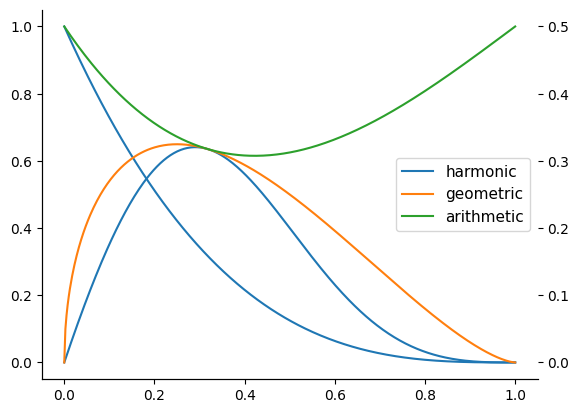

In [7]:
fig, ax1 = plt.subplots()
harmonic_mean = (2 * a * b) / (a + b) 
geo = np.sqrt(a*b)
hrm_min = harmonic_mean.argmin()
hrm_max = harmonic_mean.argmax()
geo_min = geo.argmin()
geo_max = geo.argmax()
print(f"""hrm_min: {hrm_min}
hrm_max: {hrm_max}
geo_min: {geo_min}
geo_max: {geo_max}""")
ax1.plot(a, b)
ax2 = ax1.twinx()
ax2.plot(a, harmonic_mean, label="harmonic")
ax2.plot(a, geo, label="geometric")
ax2.plot(a, (a + b) / 2, label="arithmetic")
plt.legend()
# plt.scatter([a[hrm_min], a[hrm_max]], [b[hrm_min], b[hrm_max]], label="harmonic")
# plt.scatter([a[dis_min], a[dis_max]], [b[dis_min], b[dis_max]], label="euclidean")

In [8]:
a[hrm_max], b[hrm_max], a[geo_max], b[geo_max]

(np.float64(0.2907268170426065),
 np.float64(0.3568129594027342),
 np.float64(0.2506265664160401),
 np.float64(0.42081855224426734))

In [9]:
a[hrm_max] + b[hrm_max]

np.float64(0.6475397764453408)

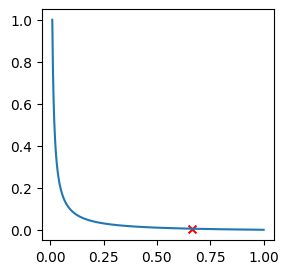

In [ ]:
import numpy as np

x = np.linspace(0.01, 1, 1000)
y = 1 / x
# y = -(x-1)**3
y = (y - y.min()) / (y.max() - y.min())

plt.figure(figsize=(3, 3))
plt.plot(x, y)
plt.scatter(x[659], y[659], marker="x", c="red", s=32)

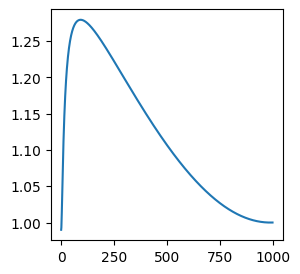

In [ ]:
max_point_x, max_point_y = 1, 1


def find_distance(x_points, y_points):
    distances = ((x_points - max_point_x) ** 2 + (y_points - max_point_y) ** 2) ** 0.5
    return distances

distances = find_distance(x, y)


plt.figure(figsize=(3, 3))


plt.plot(distances)

In [ ]:
distances.argmax()

np.int64(92)